In [147]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

In [148]:
# Set rcParams for text size
plt.rcParams.update({
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'figure.figsize': [6, 3]
})

In [149]:
import re
from datetime import datetime

# Write a function to read a log file and do the following. (1) Get the start
# timestamp from the first log line, (2) parse the log file to get each
# occurance of "test accuracy: X/Y (Z)" where X, Y and Z take some arbitrary
# values. Extract the Z value and multiply by 100. This log line will also contain the timestamp, (3)
# maintain a list of tuples where you keep appending the
# (time_elapsed_from_start, accuracy) as you iterate over the log lines and (4)
# Return this list

def parse_log_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    start_time = None
    results = []

    # Pattern to identify the specific log line to set the start_time
    init_pattern = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| .* \| /etc/flame/plugin not found; stop plugin registration')

    for line in lines:
        if start_time is None:
            # Check if this line is the first occurrence of the init message
            match = init_pattern.search(line)
            if match:
                start_time = datetime.strptime(match.group(1), '%Y-%m-%d %H:%M:%S,%f')
                continue  # Move to the next line after setting the start_time

        # Find lines with "test accuracy: X/Y (Z)"
        match = re.search(r'test accuracy: \d+/\d+ \((\d+\.\d+)\)', line)
        if match and start_time:
            timestamp = datetime.strptime(line.split(" | ")[0], '%Y-%m-%d %H:%M:%S,%f')
            time_elapsed = (timestamp - start_time).total_seconds()
            accuracy = float(match.group(1)) * 100
            results.append((time_elapsed, accuracy))

    return results

### Synthetic expt plots E2E

In [150]:
# AsyncOORT log files
async_oort_synthetic_fail_0 = parse_log_file('agg_wash_10_02_17_15_alpha100_cifar_70acc_fedbuff_asyncoort_oracular_synFail_0.log')
async_oort_unaware_synthetic_fail_20 = parse_log_file('agg_jayne_11_02_01_48_alpha100_cifar_70acc_fedbuff_asyncoort_unaware_synFail_20.log')


# OORT log files
oort_synthetic_fail_0 = parse_log_file('agg_jayne_10_02_17_13_alpha100_cifar_70acc_fedavg_oort_oracular_synFail_0.log')
oort_unaware_synthetic_fail_20 = parse_log_file('agg_jayne_11_02_09_47_alpha100_cifar_70acc_fedavg_oort_unaware_synFail_20.log')

In [ ]:
def plot_accuracy_curves(log_data_list, labels, figname, ylim=None, highlight_point=None, legend_location=None):
    """
    Plots accuracy curves for multiple log files with markers placed on every 200th entry.
    
    :param log_data_list: List of lists, where each sublist contains tuples of (time_elapsed, accuracy).
    :param labels: List of labels corresponding to each log data list.
    :param figname: Filename to save the plot.
    :param ylim: Optional y-axis limit.
    :param highlight_point: Optional tuple (x_val, y_val) to annotate the plot with an arrow and text.
    """
    styles = ['-', '--', '-', '--']  # Different line styles for better differentiation
    markers = ['s', 's', 'o', 'o']
    colors = ['blue', 'blue', 'red', 'red']  # Colors for each line

    for i, (data, label) in enumerate(zip(log_data_list, labels)):
        times, accuracies = zip(*data)  # Unpack time and accuracy
        smoothed_accuracies = gaussian_filter1d(accuracies, sigma=10)

        # Select every 200th point for markers
        marker_indices = np.arange(0, len(times), 200)
        marker_times = np.array(times)[marker_indices]
        marker_accuracies = smoothed_accuracies[marker_indices]

        # Plot the smoothed line
        plt.plot(times, smoothed_accuracies, linestyle=styles[i % len(styles)], 
                 color=colors[i % len(colors)], label=label, zorder=3)

        # Plot markers on every 200th entry
        plt.scatter(marker_times, marker_accuracies, marker=markers[i % len(markers)], 
                    color=colors[i % len(colors)], edgecolors='black', zorder=3)

    # Highlight the optional annotation if provided
    if highlight_point:
        x_val, y_val = highlight_point

        # Draw a double-headed arrow with increased arrowhead size
        plt.annotate("", xy=(x_val, y_val), xytext=(x_val, 12),
                     arrowprops=dict(arrowstyle='<->', color='black', lw=2, mutation_scale=15), zorder=3)

        # Display y_val as text at (x_val - small_offset, y_val/2)
        plt.text(x_val - 500, y_val / 2, r"$\mathbf{Gap:}$ $\mathbf{" + str(y_val-10) + r"}$" + r"$\mathit{\%}$", 
                 verticalalignment='center', horizontalalignment='right',
                 fontsize=14, color='black', zorder=3)

    plt.xlabel("Time Elapsed (s)")
    plt.ylabel("Accuracy (%)")
    if legend_location is not None:
        plt.legend(ncol=2, loc=legend_location)
    else:
        plt.legend(ncol=2) # Set legend columns to 2
    plt.grid(True, color='gainsboro', zorder=1)
    
    plt.xlim(0, 21000)
    if ylim is not None:
        plt.ylim(0, ylim)
    
    plt.savefig(f'/home/dgarg39/flame/evaluation/euromlsys25/{figname}.pdf', bbox_inches='tight')
    plt.show()

In [151]:
CLIP_LIMIT_SECONDS = 20500

# Create copies of the lists with timestamps clipped at CLIP_LIMIT_SECONDS
async_oort_synthetic_fail_0_clipped = [entry for entry in async_oort_synthetic_fail_0 if entry[0] <= CLIP_LIMIT_SECONDS]
async_oort_unaware_synthetic_fail_20_clipped = [entry for entry in async_oort_unaware_synthetic_fail_20 if entry[0] <= CLIP_LIMIT_SECONDS]
oort_synthetic_fail_0_clipped = [entry for entry in oort_synthetic_fail_0 if entry[0] <= CLIP_LIMIT_SECONDS]
oort_unaware_synthetic_fail_20_clipped = [entry for entry in oort_unaware_synthetic_fail_20 if entry[0] <= CLIP_LIMIT_SECONDS]

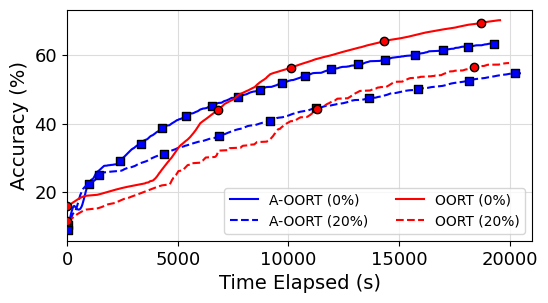

In [ ]:
# Pass the clipped versions to logs
logs = [
    async_oort_synthetic_fail_0_clipped,
    async_oort_unaware_synthetic_fail_20_clipped,
    oort_synthetic_fail_0_clipped,
    oort_unaware_synthetic_fail_20_clipped
]

labels = ["A-OORT (0%)", "A-OORT (20%)", "OORT (0%)", "OORT (20%)"]

plot_accuracy_curves(logs, labels, figname="synthetic_expt_unaware")

### Mobiperf E2E

In [152]:
# Alpha = 100 ORACLE
alpha_100_asyncoort_oracle = parse_log_file("agg_sheph_08_02_17_34_alpha100_cifar_70acc_fedbuff_asyncoort_oracular.log")
alpha_100_oort_oracle = parse_log_file("agg_wash_07_02_02_48_alpha100_cifar_70acc_fedavg_oort_oracular.log")

# Alpha = 10 ORACLE
alpha_10_asyncoort_oracle = parse_log_file("agg_jayne_08_02_17_35_alpha10_cifar_70acc_fedbuff_asyncoort_oracular.log")
alpha_10_oort_oracle = parse_log_file("agg_jayne_07_02_02_47_alpha10_cifar_70acc_fedavg_oort_oracular.log")

# Alpha = 1 ORACLE
alpha_1_asyncoort_oracle = parse_log_file("agg_jayne_08_02_23_56_alpha1_cifar_70acc_fedbuff_asyncoort_oracular.log")
alpha_1_oort_oracle = parse_log_file("agg_jayne_07_02_09_38_alpha1_cifar_70acc_fedavg_oort_oracular.log")

# Alpha = 0.1 ORACLE
alpha_0_1_asyncoort_oracle = parse_log_file("agg_wash_08_02_17_35_alpha0.1_cifar_70acc_fedbuff_asyncoort_oracular.log")
alpha_0_1_oort_oracle = parse_log_file("agg_sheph_07_02_03_20_alpha0.1_cifar_70acc_fedavg_oort_oracular.log")

In [22]:
len(alpha_0_1_oort_oracle)

2104

In [29]:
asyncoort_unaware_all_alpha = [(0, 10.5), (5000, 10.5), (10000, 10.5), (21000, 10.5)]
oort_unaware_all_alpha = [(0, 10), (5000, 10), (10000, 10), (21000, 10)]

In [153]:
# Create copies of the lists with timestamps clipped at CLIP_LIMIT_SECONDS
# Create copies of the lists with timestamps clipped at CLIP_LIMIT_SECONDS
alpha_100_asyncoort_oracle_clipped = [entry for entry in alpha_100_asyncoort_oracle if entry[0] <= CLIP_LIMIT_SECONDS]
alpha_100_oort_oracle_clipped = [entry for entry in alpha_100_oort_oracle if entry[0] <= CLIP_LIMIT_SECONDS]

alpha_10_asyncoort_oracle_clipped = [entry for entry in alpha_10_asyncoort_oracle if entry[0] <= CLIP_LIMIT_SECONDS]
alpha_10_oort_oracle_clipped = [entry for entry in alpha_10_oort_oracle if entry[0] <= CLIP_LIMIT_SECONDS]

alpha_1_asyncoort_oracle_clipped = [entry for entry in alpha_1_asyncoort_oracle if entry[0] <= CLIP_LIMIT_SECONDS]
alpha_1_oort_oracle_clipped = [entry for entry in alpha_1_oort_oracle if entry[0] <= CLIP_LIMIT_SECONDS]

alpha_0_1_asyncoort_oracle_clipped = [entry for entry in alpha_0_1_asyncoort_oracle if entry[0] <= CLIP_LIMIT_SECONDS]
alpha_0_1_oort_oracle_clipped = [entry for entry in alpha_0_1_oort_oracle if entry[0] <= CLIP_LIMIT_SECONDS]

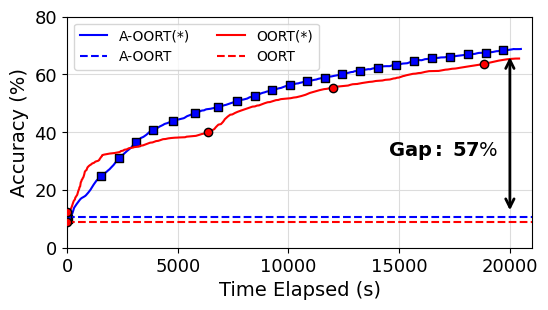

In [94]:
# Plotting for alpha=100
logs = [
    alpha_100_asyncoort_oracle_clipped,
    asyncoort_unaware_all_alpha,
    alpha_100_oort_oracle_clipped,
    oort_unaware_all_alpha
]

labels = ["A-OORT(*)", "A-OORT", "OORT(*)", "OORT"]

plot_accuracy_curves(logs, labels, figname="mobiperf_alpha100_expt_oracle_unaware", ylim=80, highlight_point=(20000, 67))

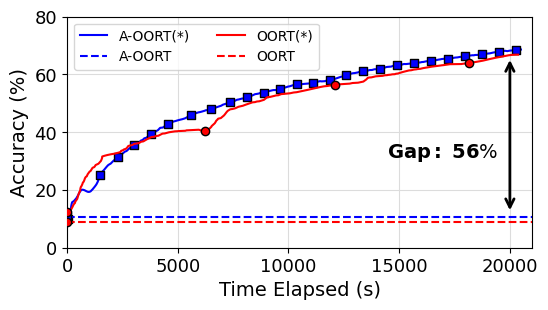

In [95]:
# Plotting for alpha=10
logs = [
    alpha_10_asyncoort_oracle_clipped,
    asyncoort_unaware_all_alpha,
    alpha_10_oort_oracle_clipped,
    oort_unaware_all_alpha
]

labels = ["A-OORT(*)", "A-OORT", "OORT(*)", "OORT"]

plot_accuracy_curves(logs, labels, figname="mobiperf_alpha10_expt_oracle_unaware", ylim=80, highlight_point=(20000, 66))

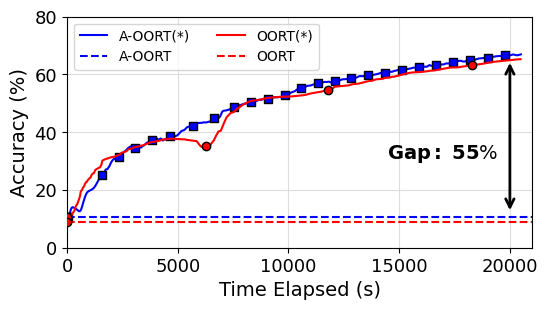

In [96]:
# Plotting for alpha=1
logs = [
    alpha_1_asyncoort_oracle_clipped,
    asyncoort_unaware_all_alpha,
    alpha_1_oort_oracle_clipped,
    oort_unaware_all_alpha
]

labels = ["A-OORT(*)", "A-OORT", "OORT(*)", "OORT"]

plot_accuracy_curves(logs, labels, figname="mobiperf_alpha1_expt_oracle_unaware", ylim=80, highlight_point=(20000, 65))

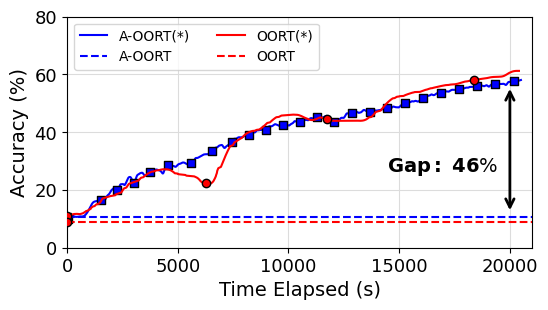

In [98]:
# Plotting for alpha=0.1
logs = [
    alpha_0_1_asyncoort_oracle_clipped,
    asyncoort_unaware_all_alpha,
    alpha_0_1_oort_oracle_clipped,
    oort_unaware_all_alpha
]

labels = ["A-OORT(*)", "A-OORT", "OORT(*)", "OORT"]

plot_accuracy_curves(logs, labels, figname="mobiperf_alpha0_1_expt_oracle_unaware", ylim=80, highlight_point=(20000, 56), legend_location="upper left")

### Update utility analysis

In [ ]:
# Create a function to take an a-oort log file. It will populate tuples
# [(timestamp, utility, staleness)]. Another function will group all values
# within 10s window and get an average value of the utility

In [5]:
# Write a function parse_util_staleness() to take a log file and look for log
# lines like: "2025-02-08 23:59:17,647 | fedbuff.py:193 | INFO | MainThread | do
# | agg ver: 28, trainer ver: 27, trainer stat_utility: 119.1889760071528, rate:
# 0.7071067811865475". Using this, it should extract the time elapsed from the
# start (log_time - first_log_timestamp), staleness (agg_ver-trainer version)
# and utility (rounded to nearest integer). These three values shoud be a tuple
# and appended to a list. Finally the list should be returned.

import re
from datetime import datetime

def parse_util_staleness(log_file):
    pattern = re.compile(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) .*? agg ver: (\d+), trainer ver: (\d+), trainer stat_utility: ([\d\.]+)")
    results = []
    first_timestamp = None
    
    with open(log_file, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                log_time_str, agg_ver, trainer_ver, utility = match.groups()
                log_time = datetime.strptime(log_time_str, "%Y-%m-%d %H:%M:%S,%f")
                
                if first_timestamp is None:
                    first_timestamp = log_time
                
                time_elapsed = (log_time - first_timestamp).total_seconds()
                staleness = int(agg_ver) - int(trainer_ver)
                utility = round(float(utility))
                
                results.append((time_elapsed, staleness, utility))
    
    return results


In [31]:
def compute_variability(numbers):
    variance = np.var(numbers)
    std_dev = np.std(numbers)
    return variance, std_dev

In [32]:
def sparsify_util_staleness(data, window_width=30):
    if not data:
        return []
    
    results = []
    start_time = 0
    end_time = window_width
    
    while start_time < data[-1][0]:
        window_data = [item for item in data if start_time <= item[0] < end_time]
        
        if window_data:
            # avg_staleness = sum(item[1] for item in window_data) / len(window_data)
            # avg_utility = sum(item[2] for item in window_data) / len(window_data)
            # results.append((end_time, avg_staleness, avg_utility))
            
            _, std_dev_staleness = compute_variability([item[1] for item in window_data])
            _, std_dev_utility = compute_variability([item[2] for item in window_data])
            results.append((end_time, std_dev_staleness, std_dev_utility))
        
        start_time = end_time
        end_time += window_width
    
    return results

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_util_staleness(data_lists, labels, colors, sigma=2):
    if not data_lists:
        return
    
    plt.figure(figsize=(12, 5))
    
    # Plot utility over time
    plt.subplot(1, 2, 1)
    for data, label, color in zip(data_lists, labels, colors):
        times = [item[0] for item in data]
        avg_utility = [item[2] for item in data]
        smoothed_utility = gaussian_filter1d(avg_utility, sigma=sigma)
        plt.plot(times, smoothed_utility, marker='.', linestyle='-', color=color, label=label)
    plt.xlabel('Time (s)')
    plt.ylabel('Std Dev Utility')
    plt.title('Utility Over Time')
    plt.yscale('log')
    plt.xlim(0, 20000)
    plt.legend()
    plt.grid(True)
    
    # Plot staleness over time
    plt.subplot(1, 2, 2)
    for data, label, color in zip(data_lists, labels, colors):
        times = [item[0] for item in data]
        avg_staleness = [item[1] for item in data]
        smoothed_staleness = gaussian_filter1d(avg_staleness, sigma=sigma)
        plt.plot(times, smoothed_staleness, marker='.', linestyle='-', color=color, label=label)
    plt.xlabel('Time (s)')
    plt.ylabel('Std Dev Staleness')
    plt.title('Staleness Over Time')
    plt.yscale('log')
    plt.xlim(0, 20000)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [145]:
# Version 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_util_staleness(data_lists, labels, colors, figname1, figname2, sigma=2):
    if not data_lists:
        return
    
    # Plot utility over time
    plt.figure(figsize=(6, 3))
    for data, label, color in zip(data_lists, labels, colors):
        times = [item[0] for item in data]
        avg_utility = [item[2] for item in data]
        smoothed_utility = gaussian_filter1d(avg_utility, sigma=sigma)
        plt.plot(times, smoothed_utility, marker='.', linestyle='-', color=color, label=label)
    plt.xlabel('Time (s)')
    plt.ylabel('Utility Standard Deviation')
    # plt.title('Utility Over Time')
    plt.yscale('log')
    plt.xlim(0, 21000)
    plt.legend()
    plt.grid(True, color='gainsboro', zorder=1)
    plt.savefig(f'/home/dgarg39/flame/evaluation/euromlsys25/{figname1}.pdf', bbox_inches='tight')
    plt.show()
    
    # Create a single CDF plot for staleness
    # plt.figure(figsize=(6, 3))
    # for data, label, color in zip(data_lists, labels, colors):
    #     staleness_values = sorted([item[1] for item in data])
    #     cdf = np.arange(1, len(staleness_values) + 1) / len(staleness_values)
    #     plt.plot(staleness_values, cdf, linestyle='-', color=color, label=label, linewidth=2)
        
    #     # Calculate P90 value
    #     # p90_value = np.percentile(staleness_values, 90)
        
    #     # Annotate P90 with text
    #     # plt.text(p90_value*1.5, 0.77, f'P90:\n{p90_value:.1f}', color=color, 
    #     #         verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

    # plt.xlabel('Staleness')
    # plt.ylabel('CDF')
    # # plt.title('Staleness CDF')
    # plt.legend()
    # # plt.yscale('log')
    # plt.xscale('log')
    # plt.grid(True, color='gainsboro', zorder=1)
    # plt.savefig(f'/home/dgarg39/flame/evaluation/euromlsys25/{figname2}.pdf', bbox_inches='tight')
    # plt.show()


In [ ]:
# MOBIPERF - ASYNCOORT
alpha100_asyncoort_util_staleness_mobiperf = parse_util_staleness("agg_sheph_08_02_17_34_alpha100_cifar_70acc_fedbuff_asyncoort_oracular.log")

alpha10_asyncoort_util_staleness_mobiperf = parse_util_staleness("agg_jayne_08_02_17_35_alpha10_cifar_70acc_fedbuff_asyncoort_oracular.log")

alpha1_asyncoort_util_staleness_mobiperf = parse_util_staleness("agg_jayne_08_02_23_56_alpha1_cifar_70acc_fedbuff_asyncoort_oracular.log")

alpha0_1_asyncoort_util_staleness_mobiperf = parse_util_staleness("agg_wash_08_02_17_35_alpha0.1_cifar_70acc_fedbuff_asyncoort_oracular.log")

In [33]:
sparsified_asyncoort_alpha100_util_staleness_mobiperf = sparsify_util_staleness(alpha100_asyncoort_util_staleness_mobiperf, 30)

sparsified_asyncoort_alpha10_util_staleness_mobiperf = sparsify_util_staleness(alpha10_asyncoort_util_staleness_mobiperf, 30)

sparsified_asyncoort_alpha1_util_staleness_mobiperf = sparsify_util_staleness(alpha1_asyncoort_util_staleness_mobiperf, 30)

sparsified_asyncoort_alpha0_1_util_staleness_mobiperf = sparsify_util_staleness(alpha0_1_asyncoort_util_staleness_mobiperf, 30)

In [137]:
util_staleness_data_lists = [
    sparsified_asyncoort_alpha100_util_staleness_mobiperf,
    sparsified_asyncoort_alpha10_util_staleness_mobiperf,
    sparsified_asyncoort_alpha1_util_staleness_mobiperf,
    sparsified_asyncoort_alpha0_1_util_staleness_mobiperf
]

labels = [r"Dir($\alpha$)=100", r"Dir($\alpha$)=10", r"Dir($\alpha$)=1", r"Dir($\alpha$)=0.1"]

colors = ['r', 'b', 'g', 'c']

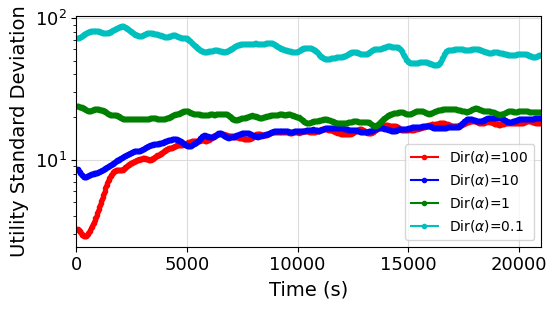

In [146]:
plot_util_staleness(util_staleness_data_lists, labels, colors, sigma=5, figname1="asyncoort_alphas_utility", figname2="temp")

### Aggregator stalls analysis

In [ ]:
# Use the processed list of acc values to get interval of times of aggregation
# For mobiperf trace, both oort and a-oort get stuck. So we can have a cdf with
# a long tail and put a cross? 

In [ ]:
# Given a list of tuples (timestamp, acc) create a new list of interval periods
# between two consecutive aggregations. Return this list of values.

# Given a function to take multiple lists and labels, plot CDFs of these lists
# of values

In [154]:
def calculate_agg_intervals(data):
    """
    Given a list of tuples (timestamp, acc), returns a list of interval periods
    between two consecutive aggregations (timestamps).
    
    Args:
    - data (list of tuples): List of (timestamp, acc) tuples sorted by timestamp.
    
    Returns:
    - List of interval periods between consecutive timestamps.
    """
    intervals = []
    for i in range(1, len(data)):
        # Calculate the difference in timestamps between consecutive elements
        interval = data[i][0] - data[i-1][0]
        intervals.append(interval)
    
    return intervals

In [191]:
def plot_agg_interval_cdf(data_lists, labels, colors, figname):
    if not data_lists:
        return
    
    # Create a single CDF plot for staleness
    plt.figure(figsize=(6, 3))
    for data, label, color in zip(data_lists, labels, colors):
        staleness_values = sorted([item for item in data])
        cdf = np.arange(1, len(staleness_values) + 1) / len(staleness_values)
        if label == "A-OORT(20%)" or label == "OORT(20%)" or label == "A-OORT" or label == "OORT":
            plt.plot(staleness_values, cdf, linestyle='--', color=color, label=label, linewidth=2)
        else:
            plt.plot(staleness_values, cdf, linestyle='-', color=color, label=label, linewidth=2) 
        
        # # Calculate P90 value
        # p90_value = np.percentile(staleness_values, 90)
        
        # # Annotate P90 with text
        # plt.text(p90_value*1.5, 0.85, f'{p90_value:.1f}', color=color, 
        #         verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

    plt.xlabel('Aggregation interval (s)')
    plt.ylabel('CDF')
    # plt.title('Staleness CDF')
    plt.legend()
    # plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, color='gainsboro', zorder=1)
    plt.savefig(f'/home/dgarg39/flame/evaluation/euromlsys25/{figname}.pdf', bbox_inches='tight')
    plt.show()

In [155]:
# PLOT FOR SYNTHETIC TRACE
asyncoort_synFail_0_agg_intervals = calculate_agg_intervals(async_oort_synthetic_fail_0_clipped)
oort_synFail_0_agg_intervals = calculate_agg_intervals(oort_synthetic_fail_0_clipped)

asyncoort_synFail_20_agg_intervals = calculate_agg_intervals(async_oort_unaware_synthetic_fail_20_clipped)
oort_synFail_20_agg_intervals = calculate_agg_intervals(oort_unaware_synthetic_fail_20_clipped)

In [159]:
len(oort_synFail_20_agg_intervals)

438

In [185]:
agg_interval_data_lists = [
    asyncoort_synFail_0_agg_intervals,
    asyncoort_synFail_20_agg_intervals,
    oort_synFail_0_agg_intervals,
    oort_synFail_20_agg_intervals
]

labels = ["A-OORT(0%)", "A-OORT(20%)", "OORT(0%)", "OORT(20%)"]

colors = ['b', 'royalblue', 'r', 'indianred']

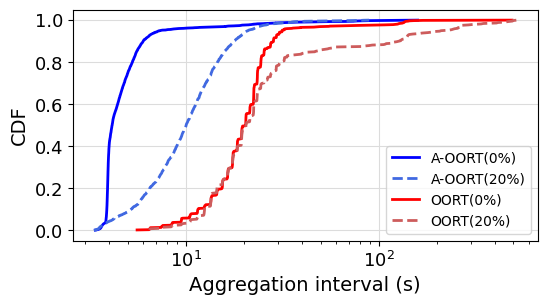

In [186]:
plot_agg_interval_cdf(agg_interval_data_lists, labels, colors, figname="agg_stalls_synthetic_avail")

In [187]:
# PLOT FOR MOBIPERF TRACE
alpha_100_asyncoort_unaware = parse_log_file("agg_wash_11_02_09_36_alpha100_cifar_70acc_fedavg_oort_unaware_mobiperf.log")
alpha_100_oort_unaware = parse_log_file("agg_sheph_11_02_03_12_alpha100_cifar_70acc_fedbuff_asyncoort_unaware_mobiperf.log")

In [188]:

alpha_100_asyncoort_oracle_mobiperf_agg_intervals = calculate_agg_intervals(alpha_100_asyncoort_oracle_clipped)
alpha_100_oort_oracle_mobiperf_agg_intervals = calculate_agg_intervals(alpha_100_oort_oracle_clipped)

asyncoort_unaware_mobiperf_agg_intervals = calculate_agg_intervals(alpha_100_asyncoort_unaware)
oort_unaware_mobiperf_agg_intervals = calculate_agg_intervals(alpha_100_oort_unaware)

In [189]:
agg_interval_data_lists = [
    alpha_100_asyncoort_oracle_mobiperf_agg_intervals,
    asyncoort_unaware_mobiperf_agg_intervals,
    alpha_100_oort_oracle_mobiperf_agg_intervals,
    oort_unaware_mobiperf_agg_intervals
]

labels = ["A-OORT(*)", "A-OORT", "OORT(*)", "OORT"]

colors = ['b', 'royalblue', 'r', 'indianred']

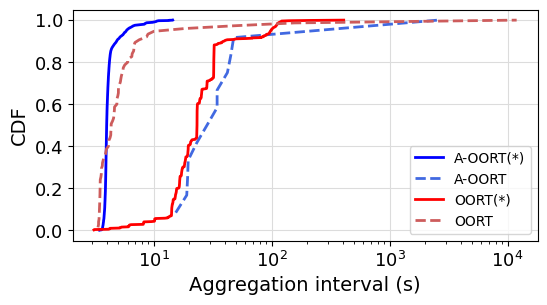

In [192]:
plot_agg_interval_cdf(agg_interval_data_lists, labels, colors, figname="agg_stalls_mobiperf_avail")

### Update staleness analysis

In [ ]:
# Use the same structure from above to create a histogram of the staleness
# distribution- with and without unavailability. A-oort (0%), A-oort (20%) and
# A-oort (mobiperf, alpha=100)

In [64]:
# SYNTHETIC - ASYNCOORT
alpha100_asyncoort_util_staleness_synFail_0 = parse_util_staleness("agg_wash_10_02_17_15_alpha100_cifar_70acc_fedbuff_asyncoort_oracular_synFail_0.log")

alpha100_asyncoort_util_staleness_synFail_20 = parse_util_staleness("agg_jayne_11_02_01_48_alpha100_cifar_70acc_fedbuff_asyncoort_unaware_synFail_20.log")

In [65]:
sparsified_alpha100_asyncoort_util_staleness_synFail_0 = sparsify_util_staleness(alpha100_asyncoort_util_staleness_synFail_0, 30)

sparsified_alpha100_asyncoort_util_staleness_synFail_20 = sparsify_util_staleness(alpha100_asyncoort_util_staleness_synFail_20, 30)

In [107]:
a_oort_alpha100_staleness_data_lists = [
    sparsified_alpha100_asyncoort_util_staleness_synFail_0,
    sparsified_alpha100_asyncoort_util_staleness_synFail_20,
    sparsified_asyncoort_alpha100_util_staleness_mobiperf
]

labels = ["A-OORT(0%)", "A-OORT(20%)", "A-OORT*(MobiPerf)"]

colors = ['r', 'b', 'g']

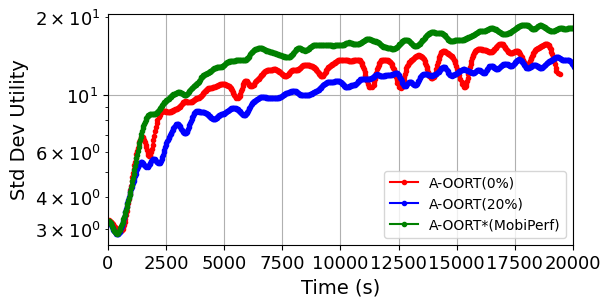

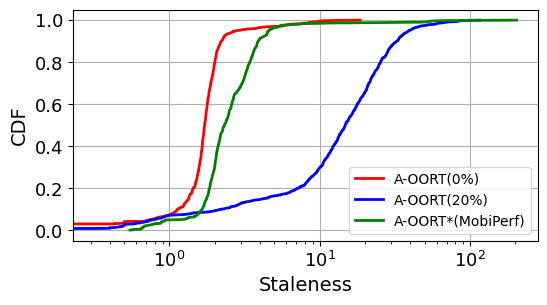

In [129]:
plot_util_staleness(a_oort_alpha100_staleness_data_lists, labels, colors, sigma=5,figname1="temp", figname2="staleness_analysis_aoort")